## Урок 7. Кейс 2. Типы моделей для задачи тарификации

### Домашнее задание (часть 1)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import catboost as catb
import warnings

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, recall_score
from sklearn.metrics import precision_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

#### 1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [2]:
# https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star
data = pd.read_csv("pulsar_stars.csv")
data.head()

Mean of the integrated profile  \
0                       140.562500   
1                       102.507812   
2                       103.015625   
3                       136.750000   
4                        88.726562   

    Standard deviation of the integrated profile  \
0                                      55.683782   
1                                      58.882430   
2                                      39.341649   
3                                      57.178449   
4                                      40.672225   

    Excess kurtosis of the integrated profile  \
0                                   -0.234571   
1                                    0.465318   
2                                    0.323328   
3                                   -0.068415   
4                                    0.600866   

    Skewness of the integrated profile   Mean of the DM-SNR curve  \
0                            -0.699648                   3.199833   
1                            -0.515088                   1.677258   
2                             1.051164                   3.121237   
3                            -0.636238                   3.642977   
4                             1.123492                   1.178930   

    Standard deviation of the DM-SNR curve  \
0                                19.110426   
1                                14.860146   
2                                21.744669   
3                                20.959280   
4                                11.468720   

    Excess kurtosis of the DM-SNR curve   Skewness of the DM-SNR curve  \
0                              7.975532                      74.242225   
1                             10.576487                     127.393580   
2                              7.735822                      63.171909   
3                              6.896499                      53.593661   
4                             14.269573                     252.567306   

   target_class  
0             0  
1             0  
2             0  
3             0  
4             0

#### 2. сделать eda (как на занятии 6 с примером для оттока)

In [3]:
print ("Rows:", data.shape[0])
print ("Columns:", data.shape[1])
print ("\nFeatures:\n", data.columns.tolist())
print ("\nMissing values:", data.isnull().sum().values.sum())
print ("\nUnique values:\n", data.nunique())

Rows: 17898
Columns: 9

Features:
 [' Mean of the integrated profile', ' Standard deviation of the integrated profile', ' Excess kurtosis of the integrated profile', ' Skewness of the integrated profile', ' Mean of the DM-SNR curve', ' Standard deviation of the DM-SNR curve', ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve', 'target_class']

Missing values: 0

Unique values:
  Mean of the integrated profile                   8626
 Standard deviation of the integrated profile    17862
 Excess kurtosis of the integrated profile       17897
 Skewness of the integrated profile              17898
 Mean of the DM-SNR curve                         9000
 Standard deviation of the DM-SNR curve          17894
 Excess kurtosis of the DM-SNR curve             17895
 Skewness of the DM-SNR curve                    17895
target_class                                         2
dtype: int64


In [4]:
data.describe()

Mean of the integrated profile  \
count                     17898.000000   
mean                        111.079968   
std                          25.652935   
min                           5.812500   
25%                         100.929688   
50%                         115.078125   
75%                         127.085938   
max                         192.617188   

        Standard deviation of the integrated profile  \
count                                   17898.000000   
mean                                       46.549532   
std                                         6.843189   
min                                        24.772042   
25%                                        42.376018   
50%                                        46.947479   
75%                                        51.023202   
max                                        98.778911   

        Excess kurtosis of the integrated profile  \
count                                17898.000000   
mean                                     0.477857   
std                                      1.064040   
min                                     -1.876011   
25%                                      0.027098   
50%                                      0.223240   
75%                                      0.473325   
max                                      8.069522   

        Skewness of the integrated profile   Mean of the DM-SNR curve  \
count                         17898.000000               17898.000000   
mean                              1.770279                  12.614400   
std                               6.167913                  29.472897   
min                              -1.791886                   0.213211   
25%                              -0.188572                   1.923077   
50%                               0.198710                   2.801839   
75%                               0.927783                   5.464256   
max                              68.101622                 223.392140   

        Standard deviation of the DM-SNR curve  \
count                             17898.000000   
mean                                 26.326515   
std                                  19.470572   
min                                   7.370432   
25%                                  14.437332   
50%                                  18.461316   
75%                                  28.428104   
max                                 110.642211   

        Excess kurtosis of the DM-SNR curve   Skewness of the DM-SNR curve  \
count                          17898.000000                   17898.000000   
mean                               8.303556                     104.857709   
std                                4.506092                     106.514540   
min                               -3.139270                      -1.976976   
25%                                5.781506                      34.960504   
50%                                8.433515                      83.064556   
75%                               10.702959                     139.309331   
max                               34.539844                    1191.000837   

       target_class  
count  17898.000000  
mean       0.091574  
std        0.288432  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [5]:
target_name = 'target_class'
feature_names = data.columns.drop(target_name).tolist()
#all_features = feature_names + [target_name]

In [6]:
data[target_name].value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

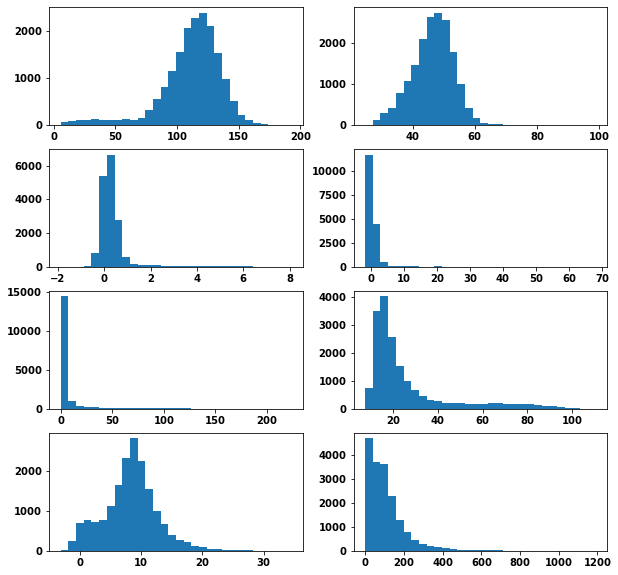

In [7]:
_, axs = plt.subplots(4, 2, figsize = (10, 10))
ax = axs.flatten()
for i, c in enumerate(feature_names):
    ax[i].hist(data[c], bins=30)

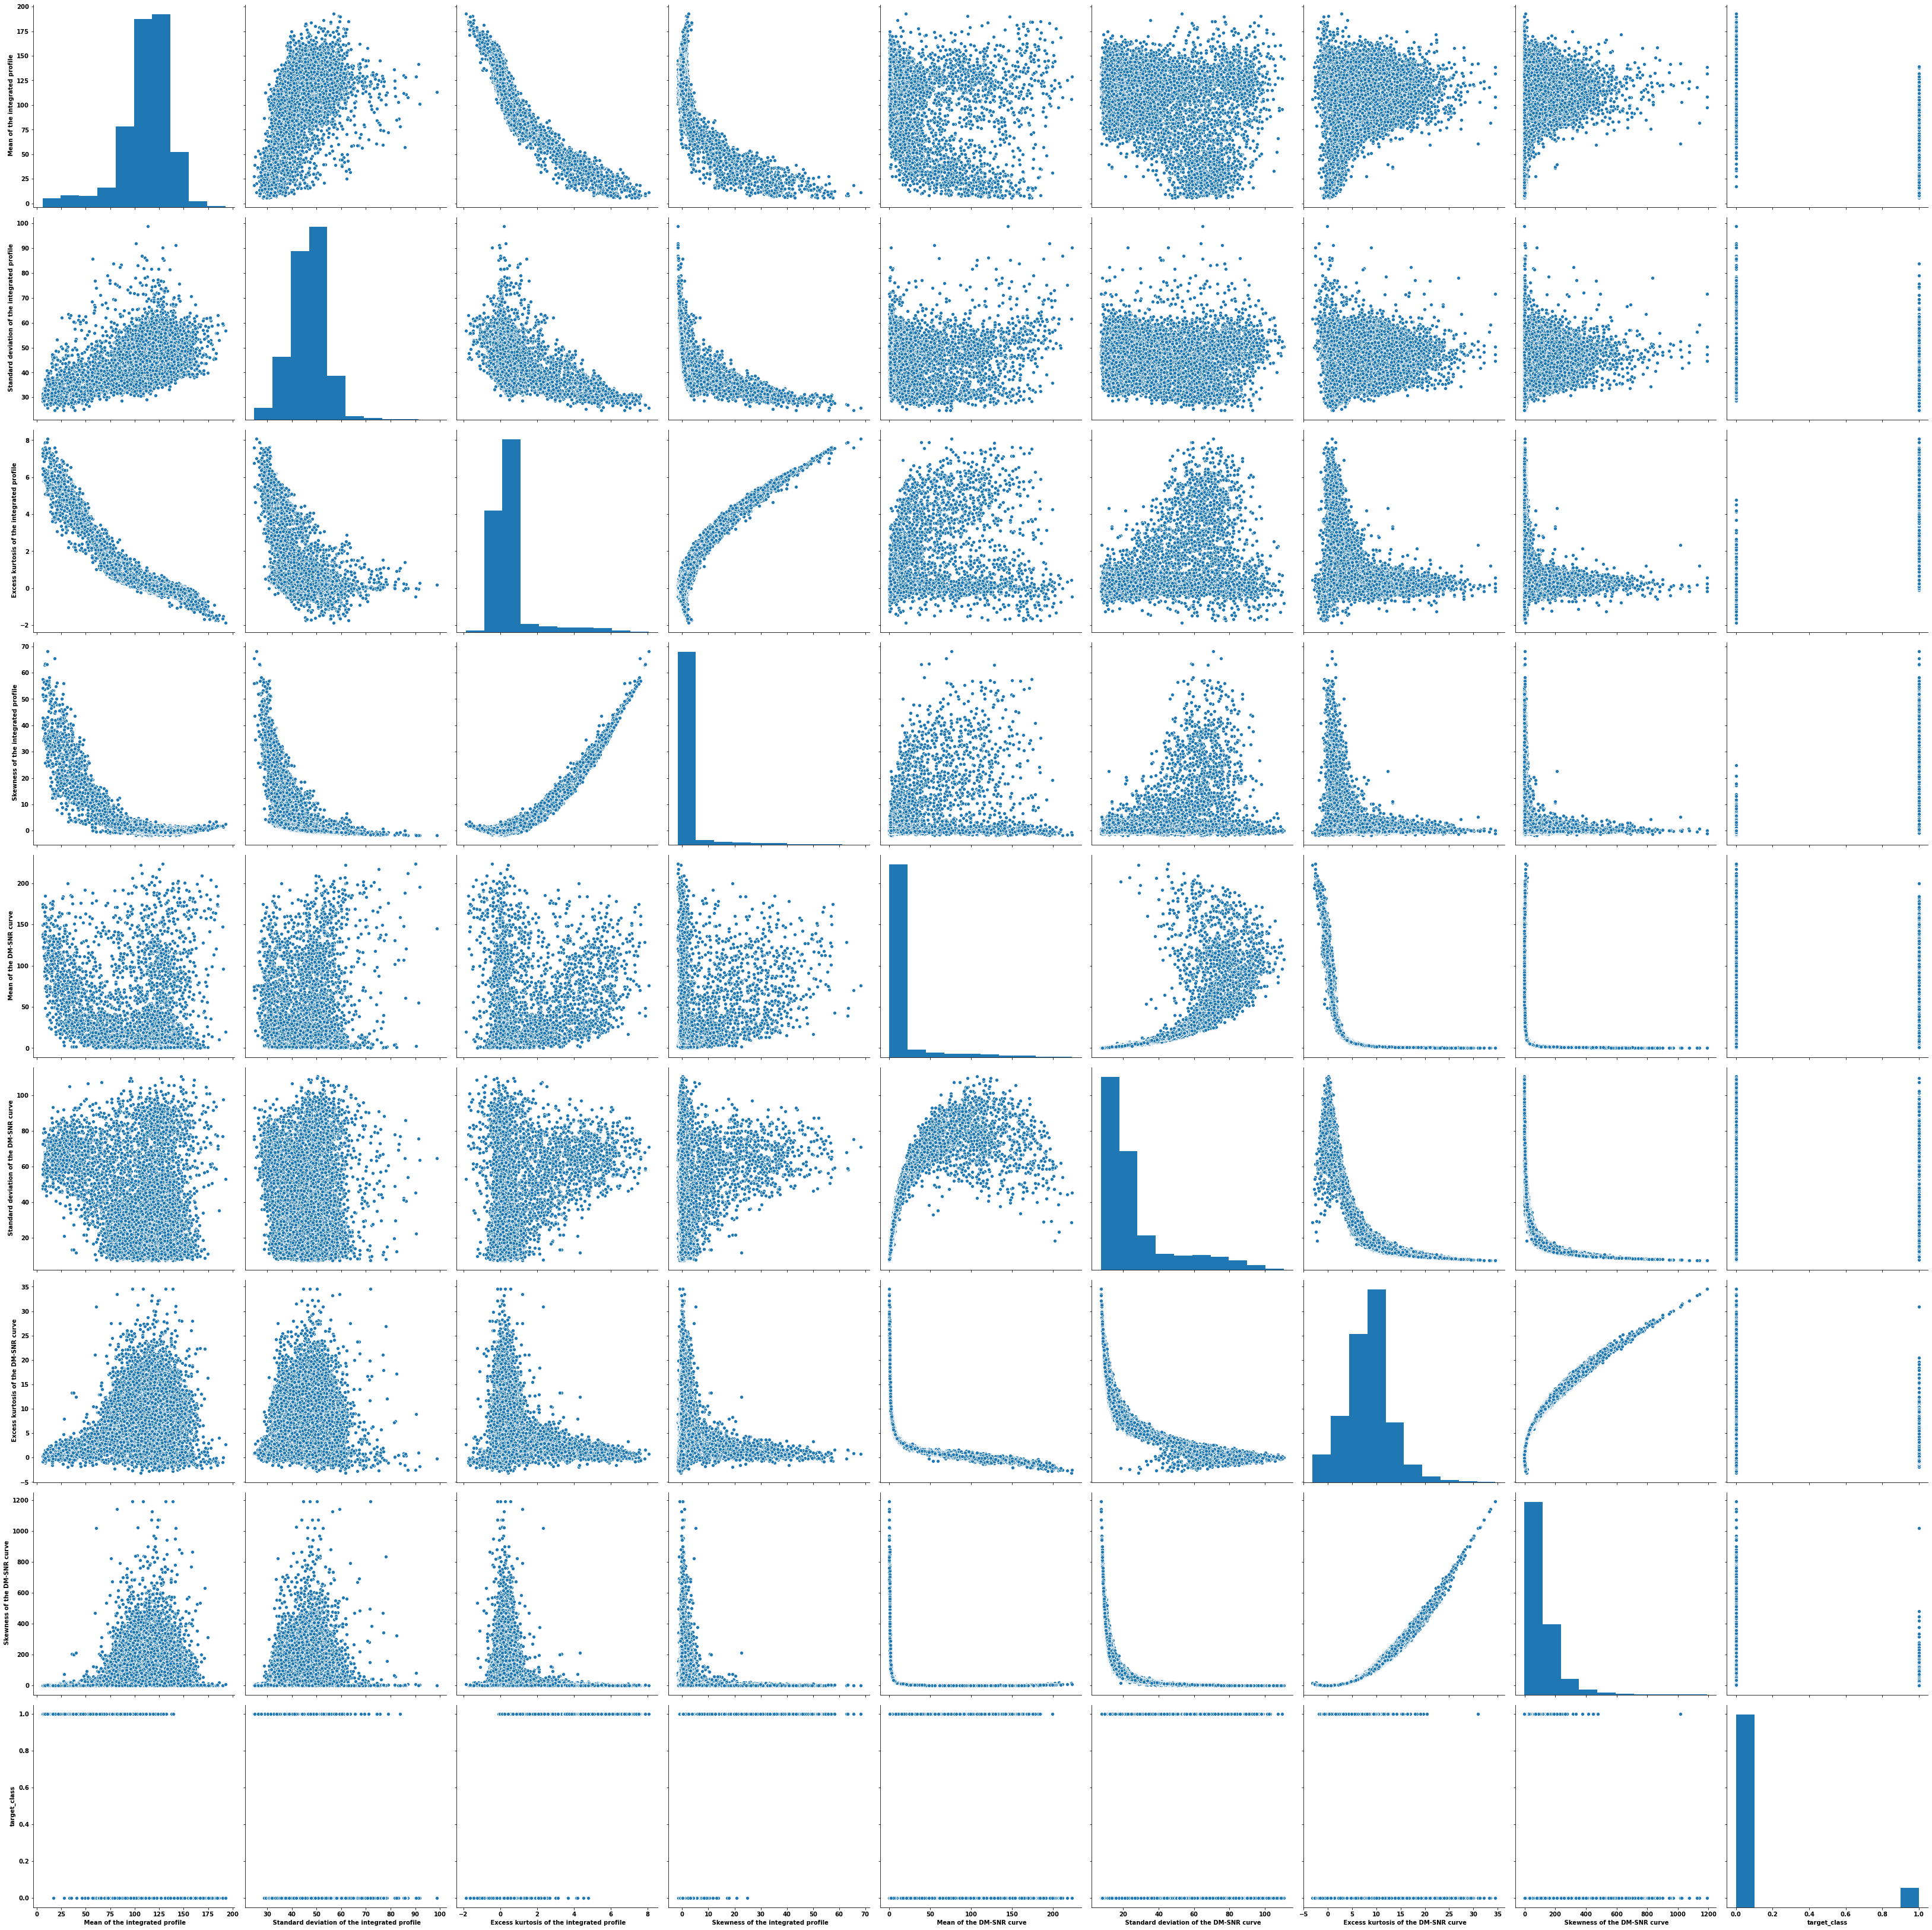

In [8]:
sns.pairplot(data, height=5)

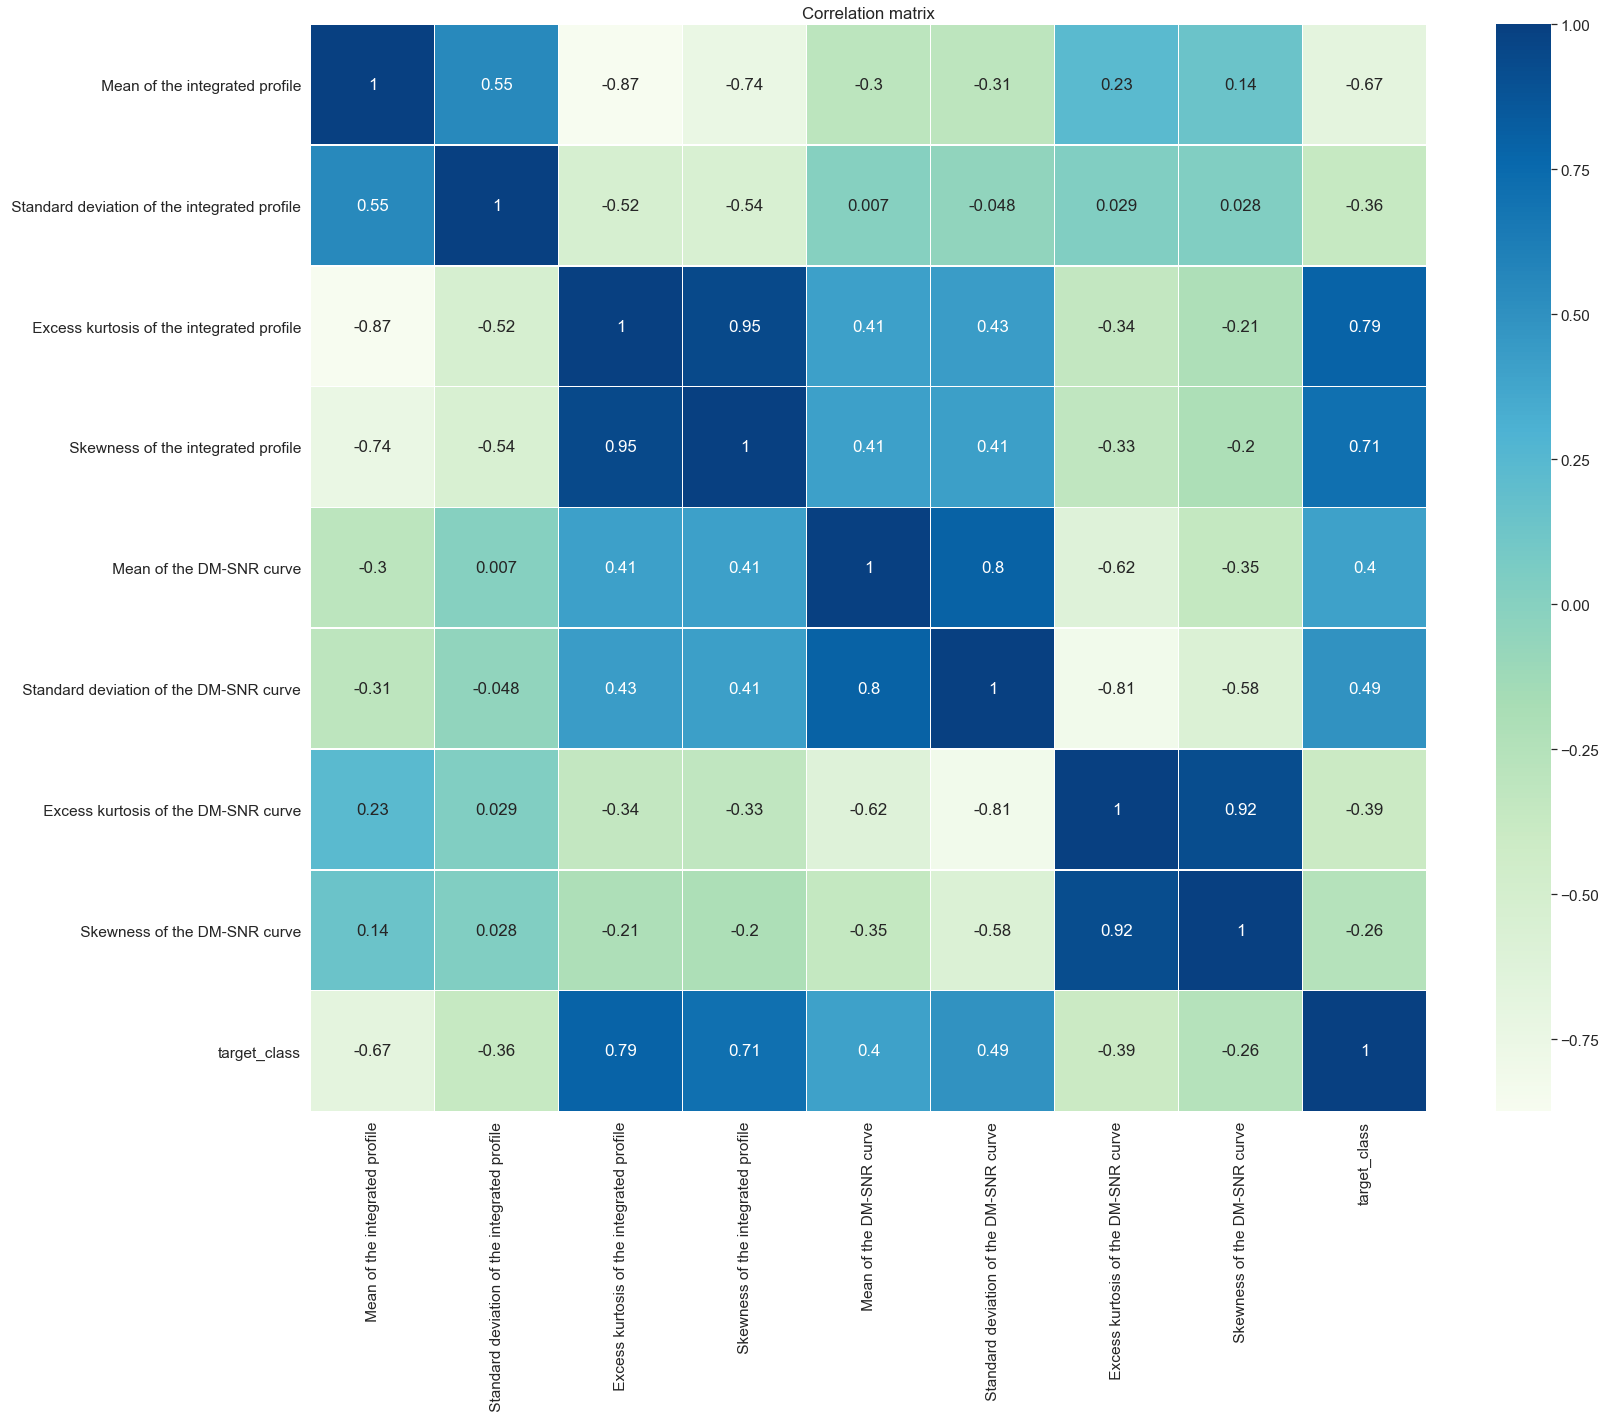

In [9]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
sns.heatmap(data.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

#### 3. сделать feature engineering

In [10]:
pca = PCA(n_components = 2)

X = data[feature_names]
Y = data[target_name]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1", "PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Pulsar"] = pca_data[target_name].replace({1:"Pulsar",0:"Not Pulsar"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["Pulsar"] == target]["PC1"] ,
                        y = pca_data[pca_data["Pulsar"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"),
                        #text = ("Customer Id : " + 
                        #        pca_data[pca_data["Churn"] == target]['customerID'])
                       )
    return tracer

layout = go.Layout(dict(title = "Visualising data with principal components",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )
trace1 = pca_scatter("Pulsar",'red')
trace2 = pca_scatter("Not Pulsar",'royalblue')
fig = go.Figure(data=[trace2,trace1],layout=layout)
py.iplot(fig)

In [11]:
data['PC1'] = pca_data['PC1']
data['PC2'] = pca_data['PC2']

feature_names = data.columns.drop(target_name).tolist()

train, test = train_test_split(data, test_size = 0.25, random_state = 0)
train_X = train[feature_names]
train_Y = train[target_name]
test_X  = test[feature_names]
test_Y  = test[target_name]

#### 4. обучить любой классификатор (какой вам нравится)

In [12]:
def data_prediction(algorithm,training_x,testing_x,
                    training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not Pulsar","Pulsar"],
                        y = ["Not Pulsar","Pulsar"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

In [13]:
model_simple = catb.CatBoostClassifier(silent=True, n_estimators = 100, max_depth = 3, class_weights=[1, 10])
data_prediction(model_simple, train_X, test_X, train_Y, test_Y, feature_names, "features", threshold_plot=False)


 Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      4115
           1       0.76      0.92      0.83       360

    accuracy                           0.97      4475
   macro avg       0.88      0.95      0.91      4475
weighted avg       0.97      0.97      0.97      4475

Accuracy   Score :  0.9700558659217877
Area under curve :  0.94823140272715 



#### 5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [14]:
mod_data = data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data[target_name].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 410/1639 as positives and unlabeling the rest


In [15]:
new_target = 'class_test'
mod_data[new_target] = -1
mod_data.loc[pos_sample, new_target] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    17488
 1      410
Name: class_test, dtype: int64


In [16]:
mod_data.head(10)

Mean of the integrated profile  \
0                       140.562500   
1                       102.507812   
2                       103.015625   
3                       136.750000   
4                        88.726562   
5                        93.570312   
6                       119.484375   
7                       130.382812   
8                       107.250000   
9                       107.257812   

    Standard deviation of the integrated profile  \
0                                      55.683782   
1                                      58.882430   
2                                      39.341649   
3                                      57.178449   
4                                      40.672225   
5                                      46.698114   
6                                      48.765059   
7                                      39.844056   
8                                      52.627078   
9                                      39.496488   

    Excess kurtosis of the integrated profile  \
0                                   -0.234571   
1                                    0.465318   
2                                    0.323328   
3                                   -0.068415   
4                                    0.600866   
5                                    0.531905   
6                                    0.031460   
7                                   -0.158323   
8                                    0.452688   
9                                    0.465882   

    Skewness of the integrated profile   Mean of the DM-SNR curve  \
0                            -0.699648                   3.199833   
1                            -0.515088                   1.677258   
2                             1.051164                   3.121237   
3                            -0.636238                   3.642977   
4                             1.123492                   1.178930   
5                             0.416721                   1.636288   
6                            -0.112168                   0.999164   
7                             0.389540                   1.220736   
8                             0.170347                   2.331940   
9                             1.162877                   4.079431   

    Standard deviation of the DM-SNR curve  \
0                                19.110426   
1                                14.860146   
2                                21.744669   
3                                20.959280   
4                                11.468720   
5                                14.545074   
6                                 9.279612   
7                                14.378941   
8                                14.486853   
9                                24.980418   

    Excess kurtosis of the DM-SNR curve   Skewness of the DM-SNR curve  \
0                              7.975532                      74.242225   
1                             10.576487                     127.393580   
2                              7.735822                      63.171909   
3                              6.896499                      53.593661   
4                             14.269573                     252.567306   
5                             10.621748                     131.394004   
6                             19.206230                     479.756567   
7                             13.539456                     198.236457   
8                              9.001004                     107.972506   
9                              7.397080                      57.784738   

   target_class         PC1        PC2  class_test  
0             0  -27.191086 -29.677875          -1  
1             0   24.476215  -6.024175          -1  
2             0  -39.938920 -10.828048          -1  
3             0  -48.000825 -29.833257          -1  
4             0  147.919433  18.562548          -1  
5             0   28.073053  -0.474673          -1  
6             0  37

In [17]:
# x_data = mod_data[feature_names].values # just the X 
# y_labeled = mod_data[new_target].values # new class (just the P & U)
# y_positive = mod_data[target_name].values # original class

#### 6. применить random negative sampling для построения классификатора в новых условиях

In [18]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data[new_target]==-1][:len(mod_data[mod_data[new_target]==1])]
sample_test = mod_data[mod_data[new_target]==-1][len(mod_data[mod_data[new_target]==1]):]
pos_sample = mod_data[mod_data[new_target]==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(410, 12) (410, 12)


In [19]:
model_rns = catb.CatBoostClassifier(silent=True, n_estimators = 100, max_depth = 3, class_weights=[1, 10])
data_prediction(model_rns, 
                sample_train[feature_names].values, 
                sample_test[feature_names].values,
                sample_train[target_name].values,
                sample_test[target_name].values,
                feature_names, "features", threshold_plot=False)


 Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.72      0.84     15871
           1       0.21      0.97      0.35      1207

    accuracy                           0.74     17078
   macro avg       0.60      0.85      0.59     17078
weighted avg       0.94      0.74      0.80     17078

Accuracy   Score :  0.7398992856306359
Area under curve :  0.8470458565139183 



#### 7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

In [20]:
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

In [21]:
model_performances = pd.concat([model_report(model_simple, train_X, test_X, train_Y, test_Y, "CatBoost Simple"),
                                model_report(model_rns, 
                                             sample_train[feature_names].values, 
                                             sample_test[feature_names].values,
                                             sample_train[target_name].values, 
                                             sample_test[target_name].values, 
                                             "CatBoost RNS")], 
                               axis = 0).reset_index()

model_performances = model_performances.drop(columns="index", axis=1)
model_performances

Model  Accuracy_score  Recall_score  Precision  f1_score  \
0  CatBoost Simple        0.970056      0.922222   0.757991   0.83208   
1     CatBoost RNS        0.739899      0.971831   0.210177   0.34561   

   Area_under_curve  Kappa_metric  
0          0.948231      0.815815  
1          0.847046      0.259558